In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Add, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Configuration
IMG_WIDTH = 256
IMG_HEIGHT = 256
CHANNELS = 3
NUM_CLASSES = 1
SEED = 42

# Updated paths for Google Drive
TRAIN_PATH = '/content/drive/MyDrive/dataset/train/'
VAL_PATH = '/content/drive/MyDrive/dataset/val/'
TEST_PATH = '/content/drive/MyDrive/dataset/test/'

print("Libraries loaded and configuration set.")

Libraries loaded and configuration set.


Data Preprocessing

In [2]:
# Define RGB colors from label_colors.txt
# Format: R G B class_name
BACKGROUND = (0, 0, 0)
OIL_COLOR = (255, 0, 124)  # Red=255, Green=0, Blue=124
OTHERS_COLOR = (255, 204, 51)
WATER_COLOR = (51, 221, 255)

def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not read image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    # Normalize to [0, 1]
    img = img / 255.0
    # Apply contrast enhancement
    img = np.clip(img * 1.2 - 0.1, 0, 1)
    return img

def load_mask(path):
    mask_rgb = cv2.imread(path)  # Load RGB image (BGR in OpenCV)
    if mask_rgb is None:
        raise ValueError(f"Could not read mask: {path}")

    # Convert BGR to RGB
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.resize(mask_rgb, (IMG_WIDTH, IMG_HEIGHT))

    # Create binary mask by detecting oil color
    binary_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

    # Extract channels
    R = mask_rgb[:, :, 0]
    G = mask_rgb[:, :, 1]
    B = mask_rgb[:, :, 2]

    # Oil pixels: RGB(255, 0, 124)
    # Allow small tolerance for compression artifacts
    oil_mask = (
        (np.abs(R.astype(int) - OIL_COLOR[0]) <= 2) &
        (np.abs(G.astype(int) - OIL_COLOR[1]) <= 2) &
        (np.abs(B.astype(int) - OIL_COLOR[2]) <= 2)
    )

    binary_mask[oil_mask] = 1.0

    # Add channel dimension
    binary_mask = np.expand_dims(binary_mask, axis=-1)

    return binary_mask

def apply_data_augmentation(img, mask, p=0.5):
    if np.random.random() < p:
        # Random horizontal flip
        if np.random.random() < 0.5:
            img = np.fliplr(img)
            mask = np.fliplr(mask)
        # Random vertical flip
        if np.random.random() < 0.5:
            img = np.flipud(img)
            mask = np.flipud(mask)
        # Random rotation (0, 90, 180, 270 degrees)
        k = np.random.randint(0, 4)
        img = np.rot90(img, k)
        mask = np.rot90(mask, k)
    return img, mask

print("Preprocessing functions defined with mask extraction.")


Preprocessing functions defined with mask extraction.


In [3]:
import re

def _first_existing_dir(base, candidates):
    for c in candidates:
        p = os.path.join(base, c)
        if os.path.isdir(p):
            return p
    return None

def _is_image_file(name):
    return name.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp'))

def _normalize(fname):
    name = os.path.splitext(fname)[0].lower()
    name = re.sub(r'(_|-)?(image|img|images|sat|satellite|photo)$', '', name)
    name = re.sub(r'(_|-)?(mask|masks|label|labels|annotation|annot|seg|segmentation)$', '', name)
    name = re.sub(r'\W+', '', name)
    return name

def load_dataset(base_path, augment=False):
    images = []
    masks = []

    img_dir = _first_existing_dir(base_path, ['image', 'images', 'img', 'imgs'])
    mask_dir = _first_existing_dir(base_path, ['mask', 'masks', 'label', 'labels', 'annotations'])

    if img_dir is None or mask_dir is None:
        all_files = [f for f in sorted(os.listdir(base_path)) if os.path.isfile(os.path.join(base_path, f)) and _is_image_file(f)]
        mask_candidates = [f for f in all_files if any(k in f.lower() for k in ('mask', 'label', 'seg', 'annot'))]
        img_candidates = [f for f in all_files if f not in mask_candidates]

        if img_dir is None and img_candidates:
            img_dir = base_path
            img_filenames = img_candidates
        elif img_dir is None:
            img_filenames = []
        else:
            img_filenames = sorted(os.listdir(img_dir))

        if mask_dir is None and mask_candidates:
            mask_dir = base_path
            mask_filenames = mask_candidates
        elif mask_dir is None:
            mask_filenames = []
        else:
            mask_filenames = sorted(os.listdir(mask_dir))
    else:
        img_filenames = sorted(os.listdir(img_dir))
        mask_filenames = sorted(os.listdir(mask_dir))

    print(f"Loading data from {base_path}...")
    print(f"Using image directory: {img_dir}")
    print(f"Using mask directory: {mask_dir}")

    if img_filenames and mask_filenames:
        mask_lookup = {}
        for m in mask_filenames:
            if not _is_image_file(m): continue
            mask_lookup[_normalize(m)] = m

        for img_name in img_filenames:
            if not _is_image_file(img_name): continue
            img_path = os.path.join(img_dir, img_name) if img_dir != base_path else os.path.join(base_path, img_name)
            norm = _normalize(img_name)

            mask_name = mask_lookup.get(norm)
            if mask_name is None:
                for k, v in mask_lookup.items():
                    if k and (norm.startswith(k) or k.startswith(norm)):
                        mask_name = v
                        break
            if mask_name is None:
                try:
                    idx = img_filenames.index(img_name)
                    if idx < len(mask_filenames):
                        mask_name = mask_filenames[idx]
                except ValueError:
                    mask_name = None
            if mask_name is None:
                print(f"Warning: no matching mask found for image {img_name}, skipping.")
                continue

            mask_path = os.path.join(mask_dir, mask_name) if mask_dir != base_path else os.path.join(base_path, mask_name)
            try:
                processed_img = load_image(img_path)
                processed_mask = load_mask(mask_path)

                # Apply augmentation for training set
                if augment:
                    processed_img, processed_mask = apply_data_augmentation(processed_img, processed_mask)

                images.append(processed_img)
                masks.append(processed_mask)
            except Exception as e:
                print(f"Error loading {img_name}: {e}")
                continue
    else:
        print("No image/mask files found in expected locations.")

    return np.array(images), np.array(masks)


In [4]:
import os

# Create dataset directories if they don't exist
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

X_train, y_train = load_dataset(TRAIN_PATH, augment=True)
X_val, y_val = load_dataset(VAL_PATH, augment=False)

print(f"\nTraining Data Shape: {X_train.shape}")
print(f"Training Mask Shape: {y_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Validation Mask Shape: {y_val.shape}")
print(f"Oil pixels in training: {np.sum(y_train > 0.5)}")
print(f"Background pixels in training: {np.sum(y_train <= 0.5)}")

import random

Loading data from /content/drive/MyDrive/dataset/train/...
Using image directory: /content/drive/MyDrive/dataset/train/images
Using mask directory: /content/drive/MyDrive/dataset/train/masks
Loading data from /content/drive/MyDrive/dataset/val/...
Using image directory: /content/drive/MyDrive/dataset/val/images
Using mask directory: /content/drive/MyDrive/dataset/val/masks

Training Data Shape: (811, 256, 256, 3)
Training Mask Shape: (811, 256, 256, 1)
Validation Data Shape: (203, 256, 256, 3)
Validation Mask Shape: (203, 256, 256, 1)
Oil pixels in training: 17115538
Background pixels in training: 36034158


In [6]:
# Verify mask loading
print("\n=== MASK LOADING DIAGNOSIS ===")
print(f"Training masks - Shape: {y_train.shape}")
print(f"Training masks - Min value: {y_train.min()}")
print(f"Training masks - Max value: {y_train.max()}")
print(f"Training masks - Mean value: {y_train.mean():.4f}")
print(f"Images with oil (>0.5): {np.sum(y_train > 0.5)}")
print(f"Images with NO oil (0): {np.sum(y_train == 0)}")

# Check a few samples
print("\nSample analysis:")
for i in range(3):
    unique_vals = np.unique(y_train[i])
    oil_pixels = np.sum(y_train[i] > 0.5)
    print(f"  Sample {i}: unique values = {unique_vals}, oil pixels = {oil_pixels}")



=== MASK LOADING DIAGNOSIS ===
Training masks - Shape: (811, 256, 256, 1)
Training masks - Min value: 0.0
Training masks - Max value: 1.0
Training masks - Mean value: 0.3220
Images with oil (>0.5): 17115538
Images with NO oil (0): 36034158

Sample analysis:
  Sample 0: unique values = [0. 1.], oil pixels = 575
  Sample 1: unique values = [0.], oil pixels = 0
  Sample 2: unique values = [0.], oil pixels = 0


Visualizing training samples:


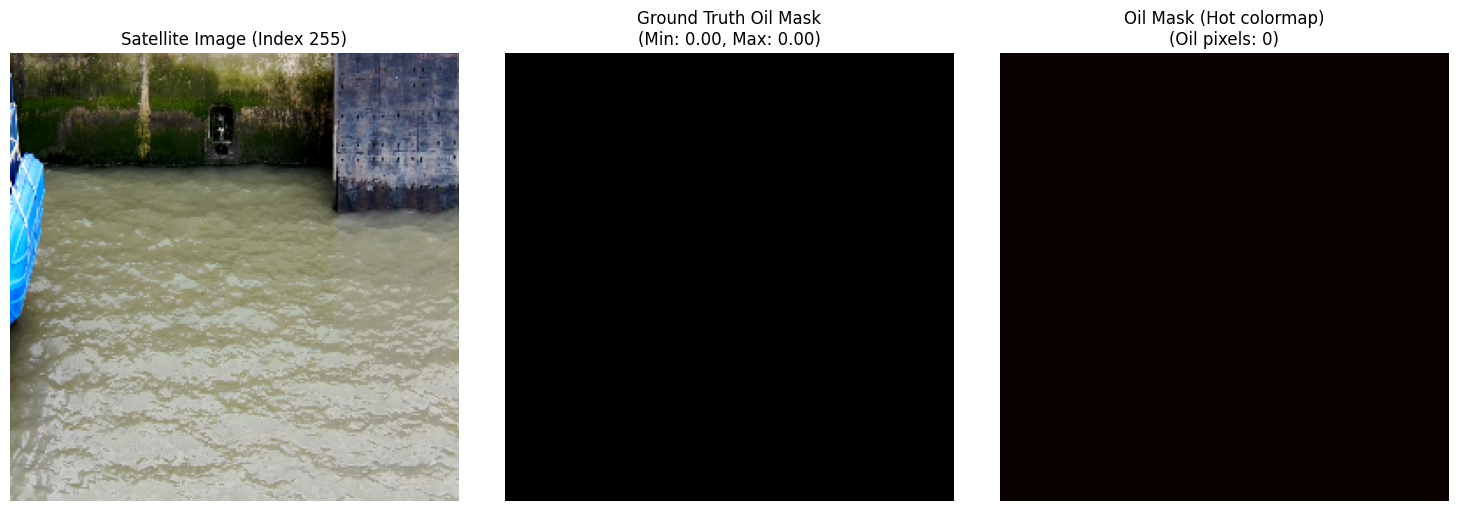

Sample 255: Oil pixels = 0/65536 (0.00%)


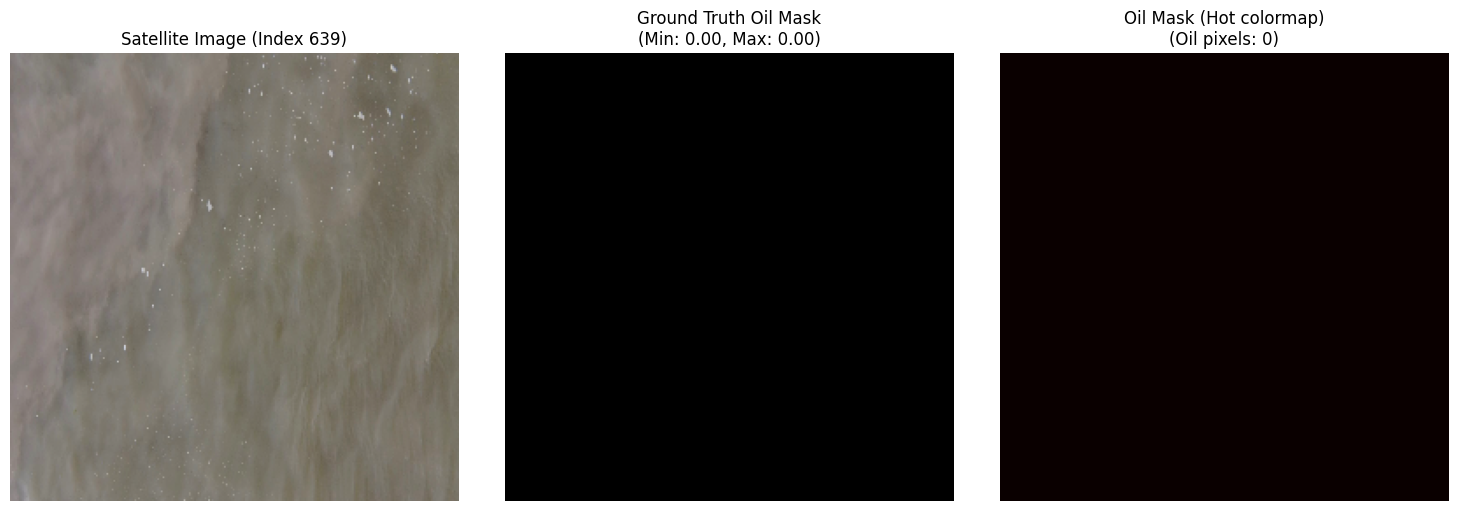

Sample 639: Oil pixels = 0/65536 (0.00%)


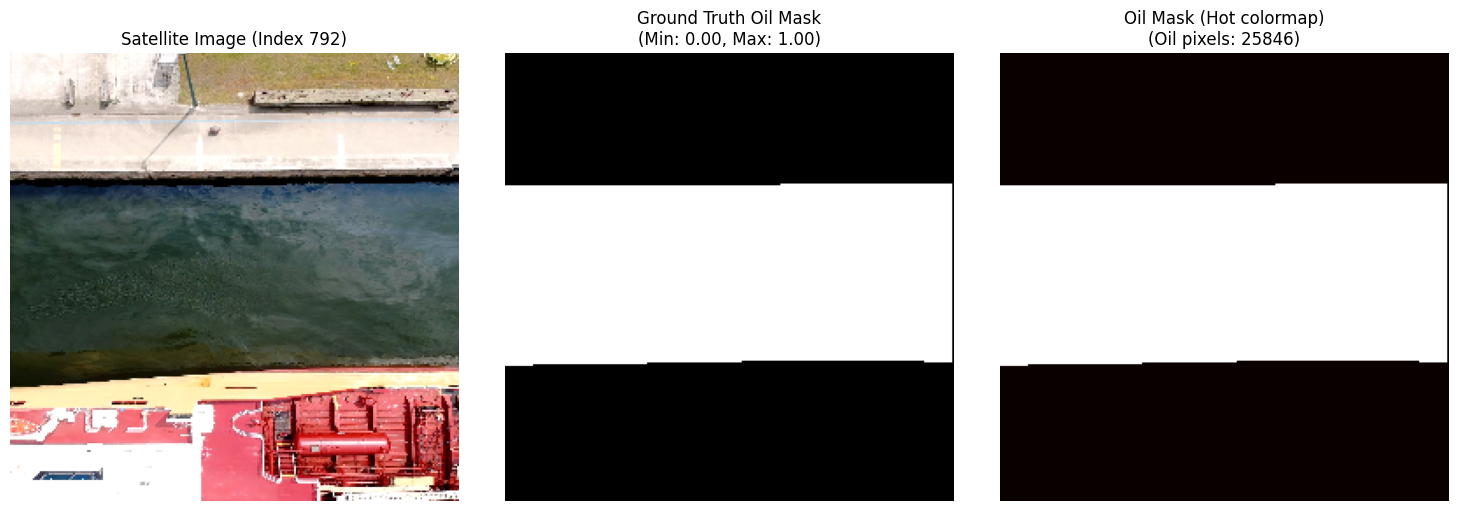

Sample 792: Oil pixels = 25846/65536 (39.44%)


In [7]:

def visualize_sample(X, y, index=None):
    if index is None:
        index = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax[0].imshow(X[index])
    ax[0].set_title(f"Satellite Image (Index {index})")
    ax[0].axis('off')

    # Ground truth mask
    mask_data = np.squeeze(y[index])
    ax[1].imshow(mask_data, cmap='gray')
    ax[1].set_title(f"Ground Truth Oil Mask\n(Min: {mask_data.min():.2f}, Max: {mask_data.max():.2f})")
    ax[1].axis('off')

    # Mask with better visualization (inverted colors for visibility)
    ax[2].imshow(mask_data, cmap='hot')
    ax[2].set_title(f"Oil Mask (Hot colormap)\n(Oil pixels: {np.sum(mask_data > 0.5)})")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    oil_count = np.sum(mask_data > 0.5)
    total_pixels = mask_data.size
    print(f"Sample {index}: Oil pixels = {oil_count}/{total_pixels} ({oil_count/total_pixels*100:.2f}%)")

# Show multiple samples to verify mask loading
print("Visualizing training samples:")
for i in range(3):
    visualize_sample(X_train, y_train)


Model Development

In [8]:
def build_improved_unet(input_shape):

    inputs = Input(input_shape)

    # Encoder
    # Block 1 - 256x256
    c1 = Conv2D(32, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    c1 = BatchNormalization()(c1)
    c1 = tf.keras.activations.relu(c1)
    c1 = Conv2D(32, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(c1)
    c1 = BatchNormalization()(c1)
    c1 = tf.keras.activations.relu(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.2)(p1)

    # Block 2 - 128x128
    c2 = Conv2D(64, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(p1)
    c2 = BatchNormalization()(c2)
    c2 = tf.keras.activations.relu(c2)
    c2 = Conv2D(64, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(c2)
    c2 = BatchNormalization()(c2)
    c2 = tf.keras.activations.relu(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.2)(p2)

    # Block 3 - 64x64
    c3 = Conv2D(128, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(p2)
    c3 = BatchNormalization()(c3)
    c3 = tf.keras.activations.relu(c3)
    c3 = Conv2D(128, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(c3)
    c3 = BatchNormalization()(c3)
    c3 = tf.keras.activations.relu(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.3)(p3)

    # Block 4 - 32x32
    c4 = Conv2D(256, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(p3)
    c4 = BatchNormalization()(c4)
    c4 = tf.keras.activations.relu(c4)
    c4 = Conv2D(256, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(c4)
    c4 = BatchNormalization()(c4)
    c4 = tf.keras.activations.relu(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.3)(p4)

    # Bottleneck - 16x16
    c5 = Conv2D(512, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(p4)
    c5 = BatchNormalization()(c5)
    c5 = tf.keras.activations.relu(c5)
    c5 = Conv2D(512, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(c5)
    c5 = BatchNormalization()(c5)
    c5 = tf.keras.activations.relu(c5)

    # Decoder
    # 32x32
    u4 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u4 = concatenate([u4, c4])
    u4 = Dropout(0.3)(u4)
    d4 = Conv2D(256, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(u4)
    d4 = BatchNormalization()(d4)
    d4 = tf.keras.activations.relu(d4)
    d4 = Conv2D(256, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(d4)
    d4 = BatchNormalization()(d4)
    d4 = tf.keras.activations.relu(d4)

    # 64x64
    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d4)
    u3 = concatenate([u3, c3])
    u3 = Dropout(0.3)(u3)
    d3 = Conv2D(128, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(u3)
    d3 = BatchNormalization()(d3)
    d3 = tf.keras.activations.relu(d3)
    d3 = Conv2D(128, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(d3)
    d3 = BatchNormalization()(d3)
    d3 = tf.keras.activations.relu(d3)

    # 128x128
    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d3)
    u2 = concatenate([u2, c2])
    u2 = Dropout(0.2)(u2)
    d2 = Conv2D(64, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(u2)
    d2 = BatchNormalization()(d2)
    d2 = tf.keras.activations.relu(d2)
    d2 = Conv2D(64, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(d2)
    d2 = BatchNormalization()(d2)
    d2 = tf.keras.activations.relu(d2)

    # 256x256
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(d2)
    u1 = concatenate([u1, c1])
    u1 = Dropout(0.2)(u1)
    d1 = Conv2D(32, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(u1)
    d1 = BatchNormalization()(d1)
    d1 = tf.keras.activations.relu(d1)
    d1 = Conv2D(32, (3, 3), activation=None, kernel_initializer='he_normal',
                 padding='same', kernel_regularizer=regularizers.l2(1e-4))(d1)
    d1 = BatchNormalization()(d1)
    d1 = tf.keras.activations.relu(d1)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_improved_unet((IMG_HEIGHT, IMG_WIDTH, CHANNELS))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

Metrics and Training

In [9]:
# Define Metrics
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def weighted_binary_crossentropy(y_true, y_pred):
    # Weight positive class 5x to combat class imbalance
    weight_for_oil = 5.0
    weight_for_background = 1.0

    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)
    bce = -(weight_for_oil * y_true * tf.math.log(y_pred) +
            weight_for_background * (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(bce)


In [10]:
# Compile with loss and optimizer
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss=weighted_binary_crossentropy,  # Weighted loss for class imbalance
              metrics=['accuracy', dice_coefficient, iou_metric])

# Compute dynamic class weight from training masks (helps with varying imbalance)
pos_frac = float(np.mean(y_train)) if y_train.size > 0 else 0.01
weight_for_oil = float(max(1.0, (1.0 - pos_frac) / (pos_frac + 1e-6)))
print(f"Computed weight_for_oil: {weight_for_oil:.3f} (pos_frac={pos_frac:.4f})")

# Redefine weighted BCE to use the computed weight
def weighted_binary_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    bce = -(weight_for_oil * y_true * tf.math.log(y_pred) +
            (1.0 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(bce)

# Dice loss (complement of Dice coefficient)
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 1.0 - dice

# Combined loss: weighted BCE + Dice loss (balances region-level and pixel-level)
def combined_loss(y_true, y_pred):
    return weighted_binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Compile with combined loss and a conservative LR schedule
optimizer = Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer,
              loss=combined_loss,
              metrics=['accuracy', dice_coefficient, iou_metric])

# Callbacks (monitoring validation Dice for best model)
checkpoint = tf.keras.callbacks.ModelCheckpoint('oil_spill_model.h5',
                                                verbose=1,
                                                save_best_only=True,
                                                monitor='val_dice_coefficient',
                                                mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coefficient',
                                                    patience=8,
                                                    verbose=1,
                                                    restore_best_weights=True,
                                                    mode='max') # Added mode='max'

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coefficient',
                                                    factor=0.5,
                                                    patience=3,
                                                    min_lr=1e-7,
                                                    verbose=1,
                                                    mode='max') # Added mode='max'

# Train with callbacks - increase epochs to allow more learning
print("Starting training with improved model and combined loss...")
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=8,
                    epochs=100,
                    callbacks=[checkpoint, early_stopping, reduce_lr],
                    verbose=1)


Computed weight_for_oil: 2.105 (pos_frac=0.3220)
Starting training with improved model and combined loss...
Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.5780 - dice_coefficient: 0.4846 - iou_metric: 0.3255 - loss: 1.9329
Epoch 1: val_dice_coefficient improved from -inf to 0.48326, saving model to oil_spill_model.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 108s 574ms/step - accuracy: 0.5787 - dice_coefficient: 0.4851 - iou_metric: 0.3260 - loss: 1.9314 - val_accuracy: 0.5883 - val_dice_coefficient: 0.4833 - val_iou_metric: 0.3457 - val_loss: 1.8689 - learning_rate: 5.0000e-05
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7765 - dice_coefficient: 0.6311 - iou_metric: 0.4678 - loss: 1.5081
Epoch 2: val_dice_coefficient improved from 0.48326 to 0.52482, saving model to oil_spill_model.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.7766 - dice_coefficient: 0.6312 - iou_metric: 0.4679 - loss: 1.5078 - val_accuracy: 0.4586 - val_dice_coefficient: 0.5248 - val_iou_metric: 0.3914 - val_loss: 2.0931 - learning_rate: 5.0000e-05
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7998 - dice_coefficient: 0.6571 - iou_metric: 0.4975 - loss: 1.4258
Epoch 3: val_dice_coefficient improved from 0.52482 to 0.54406, saving model to oil_spill_model.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.7999 - dice_coefficient: 0.6572 - iou_metric: 0.4976 - loss: 1.4255 - val_accuracy: 0.6443 - val_dice_coefficient: 0.5441 - val_iou_metric: 0.4076 - val_loss: 1.8048 - learning_rate: 5.0000e-05
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8415 - dice_coefficient: 0.7059 - iou_metric: 0.5560 - loss: 1.2863
Epoch 4: val_dice_coefficient did not improve from 0.54406
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.8415 - dice_coefficient: 0.7058 - iou_metric: 0.5559 - loss: 1.2864 - val_accuracy: 0.6195 - val_dice_coefficient: 0.5399 - val_iou_metric: 0.4033 - val_loss: 1.9563 - learning_rate: 5.0000e-05
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8400 - dice_coefficient: 0.7062 - iou_metric: 0.5558 - loss: 1.2798
Epoch 5: val_dice_coefficient did not improve from 0.54406
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.8401 - dice_coefficient: 0.7062 - iou_metric: 

102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.8663 - dice_coefficient: 0.7401 - iou_metric: 0.5944 - loss: 1.1723 - val_accuracy: 0.5644 - val_dice_coefficient: 0.5450 - val_iou_metric: 0.4154 - val_loss: 2.1387 - learning_rate: 5.0000e-05
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8555 - dice_coefficient: 0.7319 - iou_metric: 0.5876 - loss: 1.2014
Epoch 7: val_dice_coefficient improved from 0.54502 to 0.56776, saving model to oil_spill_model.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.8556 - dice_coefficient: 0.7320 - iou_metric: 0.5876 - loss: 1.2011 - val_accuracy: 0.6519 - val_dice_coefficient: 0.5678 - val_iou_metric: 0.4328 - val_loss: 1.8212 - learning_rate: 5.0000e-05
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8806 - dice_coefficient: 0.7524 - iou_metric: 0.6131 - loss: 1.1150
Epoch 8: val_dice_coefficient did not improve from 0.56776
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.8806 - dice_coefficient: 0.7522 - iou_metric: 0.6130 - loss: 1.1153 - val_accuracy: 0.6294 - val_dice_coefficient: 0.5635 - val_iou_metric: 0.4286 - val_loss: 1.8632 - learning_rate: 5.0000e-05
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8828 - dice_coefficient: 0.7710 - iou_metric: 0.6342 - loss: 1.0808
Epoch 9: val_dice_coefficient did not improve from 0.56776
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.8827 - dice_coefficient: 0.7707 - iou_metric: 

102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.8769 - dice_coefficient: 0.7498 - iou_metric: 0.6079 - loss: 1.1003 - val_accuracy: 0.7563 - val_dice_coefficient: 0.5936 - val_iou_metric: 0.4576 - val_loss: 1.5236 - learning_rate: 5.0000e-05
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8695 - dice_coefficient: 0.7595 - iou_metric: 0.6199 - loss: 1.1104
Epoch 11: val_dice_coefficient did not improve from 0.59362
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.8695 - dice_coefficient: 0.7594 - iou_metric: 0.6198 - loss: 1.1104 - val_accuracy: 0.6958 - val_dice_coefficient: 0.5665 - val_iou_metric: 0.4310 - val_loss: 1.7340 - learning_rate: 5.0000e-05
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8959 - dice_coefficient: 0.7752 - iou_metric: 0.6434 - loss: 1.0333
Epoch 12: val_dice_coefficient did not improve from 0.59362
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.8959 - dice_coefficient: 0.7751 - iou_metr

102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.8864 - dice_coefficient: 0.7617 - iou_metric: 0.6291 - loss: 1.0611 - val_accuracy: 0.7575 - val_dice_coefficient: 0.6022 - val_iou_metric: 0.4703 - val_loss: 1.4891 - learning_rate: 5.0000e-05
Epoch 14/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8998 - dice_coefficient: 0.7981 - iou_metric: 0.6702 - loss: 0.9942
Epoch 14: val_dice_coefficient did not improve from 0.60219
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.8998 - dice_coefficient: 0.7978 - iou_metric: 0.6699 - loss: 0.9947 - val_accuracy: 0.7349 - val_dice_coefficient: 0.5851 - val_iou_metric: 0.4496 - val_loss: 1.6124 - learning_rate: 5.0000e-05
Epoch 15/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9000 - dice_coefficient: 0.7825 - iou_metric: 0.6488 - loss: 1.0125
Epoch 15: val_dice_coefficient did not improve from 0.60219
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.8999 - dice_coefficient: 0.7824 - iou_metr

102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.9220 - dice_coefficient: 0.8201 - iou_metric: 0.7043 - loss: 0.8871 - val_accuracy: 0.7839 - val_dice_coefficient: 0.6083 - val_iou_metric: 0.4749 - val_loss: 1.5058 - learning_rate: 1.2500e-05
Epoch 21/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9201 - dice_coefficient: 0.8242 - iou_metric: 0.7068 - loss: 0.8888
Epoch 21: val_dice_coefficient did not improve from 0.60833
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9201 - dice_coefficient: 0.8242 - iou_metric: 0.7068 - loss: 0.8888 - val_accuracy: 0.7313 - val_dice_coefficient: 0.5877 - val_iou_metric: 0.4497 - val_loss: 1.6574 - learning_rate: 1.2500e-05
Epoch 22/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9233 - dice_coefficient: 0.8252 - iou_metric: 0.7104 - loss: 0.8795
Epoch 22: val_dice_coefficient did not improve from 0.60833
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.9233 - dice_coefficient: 0.8250 - iou_metr

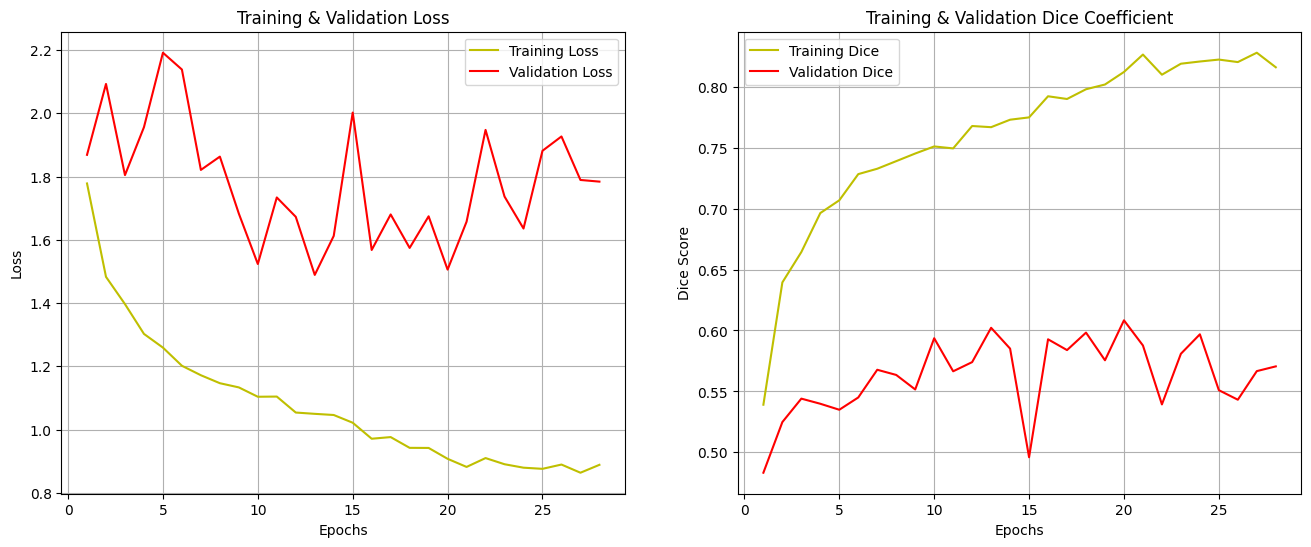

In [11]:
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice = history.history['dice_coefficient']
    val_dice = history.history['val_dice_coefficient']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(16, 6))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'y', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(epochs, dice, 'y', label='Training Dice')
    plt.plot(epochs, val_dice, 'r', label='Validation Dice')
    plt.title('Training & Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training_history(history)

Visualization of Results

Showing validation predictions:


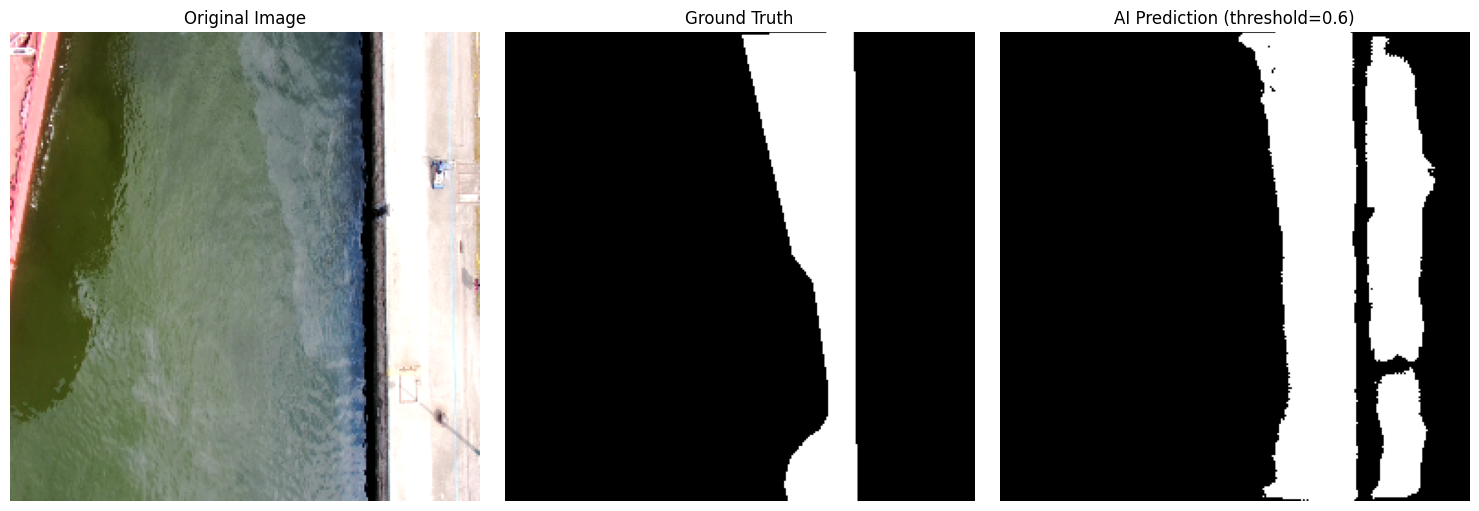

Predicted oil coverage: 28.96%


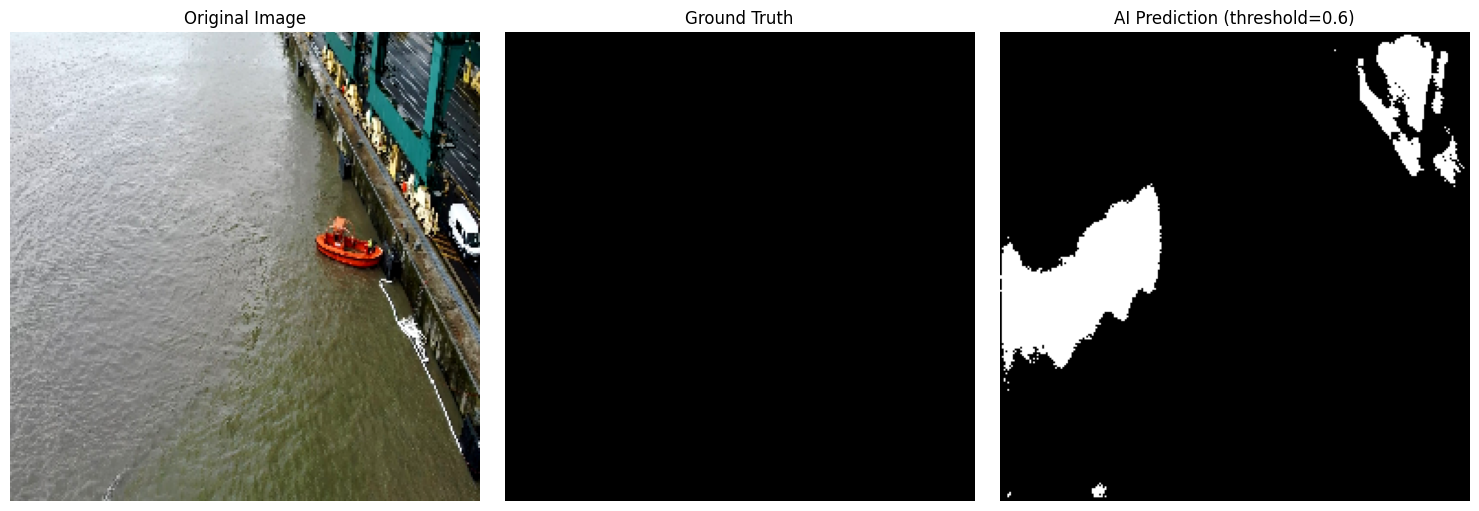

Predicted oil coverage: 12.66%


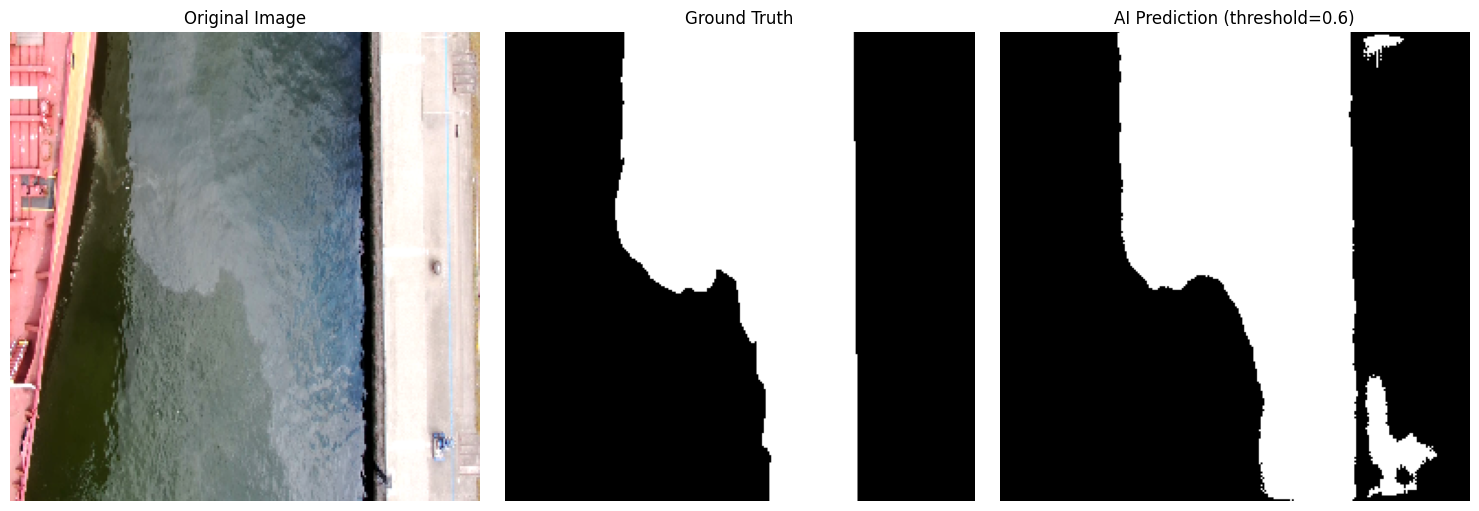

Predicted oil coverage: 39.79%


In [20]:
# Load the saved model
best_model = tf.keras.models.load_model('oil_spill_model.h5',
                                        custom_objects={'dice_coefficient': dice_coefficient,
                                                        'iou_metric': iou_metric,
                                                        'weighted_binary_crossentropy': weighted_binary_crossentropy,
                                                        'dice_loss': dice_loss,
                                                        'combined_loss': combined_loss})

def visualize_prediction(model, X, y, index=None):
    if index is None:
        index = random.randint(0, len(X) - 1)

    # Get prediction
    img = X[index]
    true_mask = y[index]

    # Predict - expects shape (1, 256, 256, 3)
    pred_mask = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]

    # Use higher threshold (0.6 instead of 0.5) to reduce false positives
    pred_mask_binary = (pred_mask > 0.6).astype(np.float32)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(np.squeeze(true_mask), cmap='gray')
    ax[1].set_title("Ground Truth")
    ax[1].axis('off')

    ax[2].imshow(np.squeeze(pred_mask_binary), cmap='gray')
    ax[2].set_title("AI Prediction (threshold=0.6)")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print prediction confidence
    oil_pixels = np.sum(pred_mask > 0.5) / pred_mask.size
    print(f"Predicted oil coverage: {oil_pixels*100:.2f}%")

# Show examples from validation set
print("Showing validation predictions:")
for i in range(3):
    visualize_prediction(best_model, X_val, y_val)